In [1]:
%%html
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
<style>
.rendered_html td {
    font-size: xx-large;
    text-align: left; !important
}
.rendered_html th {
    font-size: xx-large;
    text-align: left; !important
}
</style>

In [25]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("..")
import statnlpbook.util as util
import statnlpbook.sequence as seq
from statnlpbook.gmb import load_gmb_dataset
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
from collections import defaultdict, Counter
from random import random

from IPython.display import Image

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\bar}{\,|\,}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

In [26]:
%load_ext tikzmagic

The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


# Sequence Labelling

+ POS tagging
+ Log-linear models
+ IOB encoding
+ Named entity recognition
+ Evaluating sequence labelers
+ Maximum-entropy Markov models

## Sequence Labelling

+ Assigning exactly one label to each element in a sequence

+ In context of RNNs or other sequence models, example of **one-to-one** paradigm

<center><img src="../../../../../img/one_to_one.png"></center>


(In the example: Universal Semantic Tags from [Abzianidze and Bos (2017)](https://www.aclweb.org/anthology/W17-6901.pdf))

## Parts of speech (POS)

- Group words with **similar grammatical properties**
- [Penn Treebank](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) is the most commonly used POS tag set for English
  - Has 36 POS tags and 12 other tags (for punctuation and currency symbols)
  - For example, distinguishes four types of nouns and six types of verbs

| | | |
|-|-|-|
| **NN** | noun, singular or mass | *cat, rain* |
| **NNS** | noun, plural | *cats, tables* |
| **NNP** | proper noun, singular | *John, IBM* |
| **NNPS** | proper noun, plural | *Muslims, Philippines* |


- Granularity of tags can differ

## Task: POS tagging

Assign each word in a sentence its **part-of-speech (POS) tag**.

| 1 | 2 | 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|-|-|
| I | predict | that | it | will | rain | tonight |
| PRP | VBP | IN | PRP | MD | VB | NN |

## Example

Let's look at the [GMB (Groningen Meaning Bank) dataset](https://www.kaggle.com/shoumikgoswami/annotated-gmb-corpus/), annotated with the Penn Treebank tag set


In [27]:
tokens, pos, ents = load_gmb_dataset('../data/gmb/GMB_dataset_utf8.txt')

pd.DataFrame([tokens[2], pos[2]])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,They,marched,from,the,Houses,of,Parliament,to,a,rally,in,Hyde,Park,.
1,PRP,VBD,IN,DT,NNS,IN,NN,TO,DT,NN,IN,NNP,NNP,.


In [28]:
examples = {}
counts = Counter(tag for sent in pos for tag in sent)
words = defaultdict(set)
for x_s, y_s in zip(tokens, pos):
    for i, (x, y) in enumerate(zip(x_s, y_s)):
        if (y not in examples) or (random() > 0.97):
            examples[y] = [x_s[j] + "/" + y_s[j] if i == j else x_s[j] for j in range(max(i-2,0),min(i+3,len(x_s)))]
        words[y].add(x)
sorted_tags = sorted(counts.items(),key=lambda x:-x[1])
sorted_tags_with_examples = [(t,c,len(words[t])," ".join(examples[t])) for t,c in sorted_tags]

sorted_tags_table = pd.DataFrame(sorted_tags_with_examples, columns=['Tag','Count','Unique Tokens','Example'])

In [29]:
sorted_tags_table[:10]

,Tag,Count,Unique Tokens,Example
0,NN,9307,2087,'s transitional government-in-exile/NN met Tue...
1,NNP,8189,2069,restrictions on U.N./NNP peacekeepers in
2,IN,7759,94,way out of/IN the stalemate
3,DT,6310,40,The/DT chief investigating
4,JJ,4875,1214,It is unclear/JJ how many
5,NNS,4803,1102,Both men/NNS have yet
6,.,2992,3,peace process ./.
7,VBD,2429,470,Israel completed/VBD its handover
8,VBN,2060,588,2001 have put/VBN $ 880
9,",",1953,1,"said Hezbollah ,/, along with"


<BarContainer object of 41 artists>

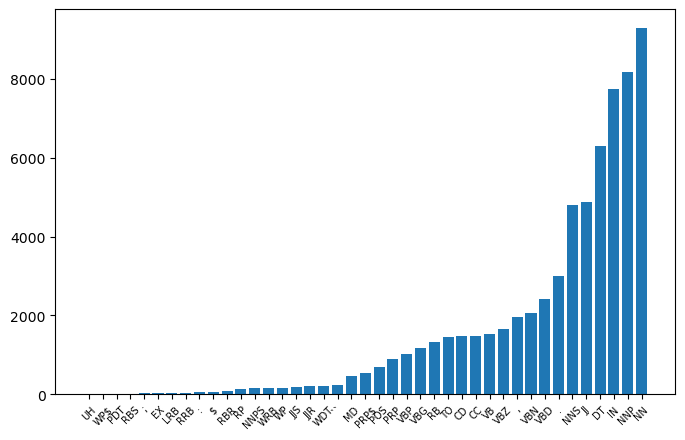

In [30]:
plt.xticks(rotation=45, fontsize=7)
plt.bar(sorted(counts.keys(), key=counts.get), sorted(counts.values()))

## Sequence Labelling as Structured Prediction

* Input Space $\Xs$: sequences of items to label
* Output Space $\Ys$: sequences of output labels
* Model: $s_{\params}(\x,\y)$
* Prediction: $\argmax_\y s_{\params}(\x,\y)$

## Conditional Models
Model probability distributions over label sequences $\y$ conditioned on input sequences $\x$

$$
s_{\params}(\x,\y) = \prob_\params(\y|\x)
$$

* Just like the conditional models from the [text classification](doc_classify_slides_short.ipynb) chapter

* But the label space is *exponential* (as a function of sequence length)!

* Most unique $\y$ are never even seen in training

* Might be useful to **break it up**?

## Local Models / Classifiers
A **fully factorised** or **local** model:

$$
p_\params(\y|\x) = \prod_{i=1}^n p_\params(y_i|\x,i,y_{1,\ldots,i-1}) \approx \prod_{i=1}^n p_\params(y_i|\x,i)
$$

* Assumption: labels are independent of each other given the input
* Inference in this model is trivial: **greedy decoding**

$$
\prob_\params(\text{"PRP MD VB"} \bar \text{"it will rain"}) \approx \\\\ \prob_\params(\text{"PRP"}\bar \text{"it will rain"},1) \cdot \\ \prob_\params(\text{"MD"} \bar \text{"it will rain"},2) \cdot \\ \prob_\params(\text{"VB"} \bar \text{"it will rain"},3)
$$

Does this remind you of anything you've seen in previous lectures?

$$
\prob_\params(\text{"it will rain"}) \approx \prob_\params(\text{"it"}) \cdot \prob_\params(\text{"will"} \bar \text{"it"}) \cdot \prob_\params(\text{"rain"} \bar \text{"it will"})
$$

### Graphical Representation

- Models can be represented as factor graphs
- Each variable of the model (our per-token tag labels and the input sequence $\x$) is drawn using a circle
- *Observed* variables are shaded
- Each factor in the model (terms in the product) is drawn as a box that connects the variables that appear in the corresponding term
   - For example, the term $p_\params(y_3|\x,3)$ would connect the variables $y_3$ and $\x$. 

### Parametrisation

**Log-linear multiclass classifier** $p_\params(y\bar\x,i)$ to predict class for sentence $\x$ and position $i$

$$
  p_\params(y\bar\x,i) \approx \frac{1}{Z_\x} \exp \langle \repr(\x,i),\params_y \rangle
$$


+ $\repr(\x,i)$ is a **feature function**
+ ${Z_\x} > 0$ is a normalisation factor to ensure that $\sum_{y} p_\params(y\bar\x,i) = 1$

+ How far can we get with very simple features that only consider the word types (and no context)?

Bias:
$$
\repr_0(\x,i) = 1
$$

Word at token to tag:
$$
\repr_w(\x,i) = \begin{cases}1 \text{ if }x_i=w \\\\ 0 \text{ else} \end{cases}
$$

In [32]:
def feat_1(x,i):
    return {
        'bias': 1.0,
        'word:' + x[i]: 1.0,
    }

train = list(zip(tokens[:-200], pos[:-200]))
dev = list(zip(tokens[-200:], pos[-200:]))

local_1 = seq.LocalSequenceLabeler(feat_1, train, class_weight='balanced')

We can assess the accuracy of this model on the development set.

In [33]:
seq.accuracy(dev, local_1.predict(dev))

0.8872215709261431

### Problem 1: unknown words

Many words are new, but we should still be able to tag them based on form or context:

> ’Twas brillig, and the slithy toves  
Did gyre and gimble in the wabe:  
All mimsy were the borogoves,  
And the mome raths outgrabe.

(Jabberwocky by Lewis Carroll)

### How to Improve?

Look at **confusion matrix**

In [34]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 7]
import matplotlib.pylab as plb
plb.rcParams['figure.dpi'] = 120

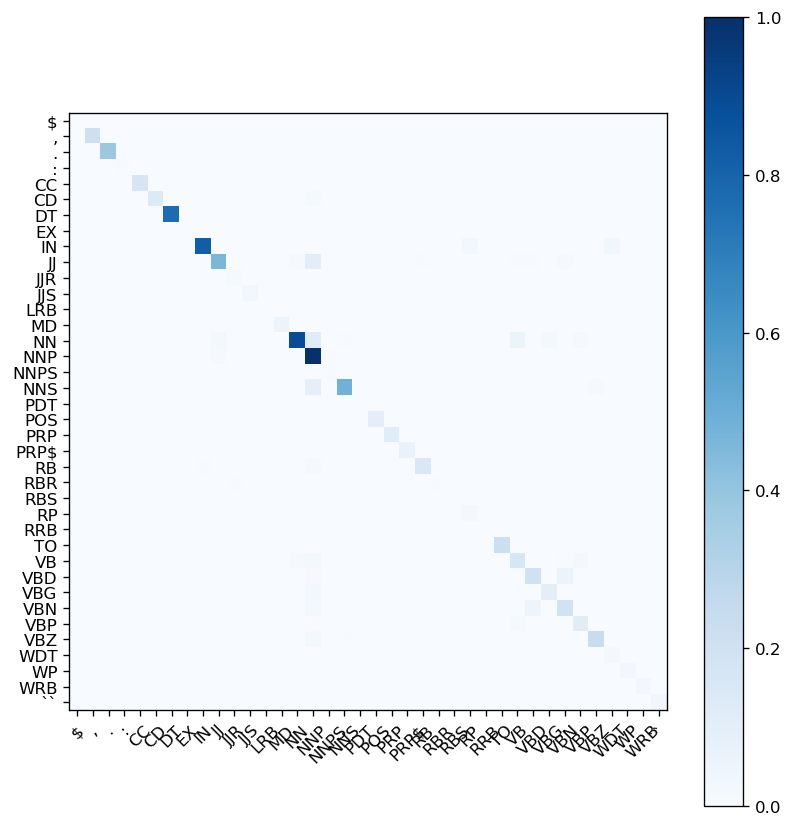

In [35]:
seq.plot_confusion_matrix(dev, local_1.predict(dev), normalise=True)

* mostly strong diagonal (good predictions)
* `NN` receives a lot of wrong counts, often confused with `NNP`

In [36]:
util.Carousel(local_1.errors(dev,
                             filter_gold=lambda y: y=='NN',
                             filter_guess=lambda y: y=='NNP'))

* "walkout", "commute", "wage" are misclassified as proper nouns
* For $f_{\text{word},w}$ feature template weights are $0$

The word has not appeared in the training set!

Proper nouns tend to be capitalised! Can we capture that with a feature?

In [37]:
def feat_2(x,i):
    return {
        'bias': 1.0,
        'word:' + x[i].lower(): 1.0,
        'first_upper:' + str(x[i][0].isupper()): 1.0,
    }
local_2 = seq.LocalSequenceLabeler(feat_2, train)
seq.accuracy(dev, local_2.predict(dev))

0.9087924970691676

Are these results actually caused by improved `NN`/`NNP` prediction?

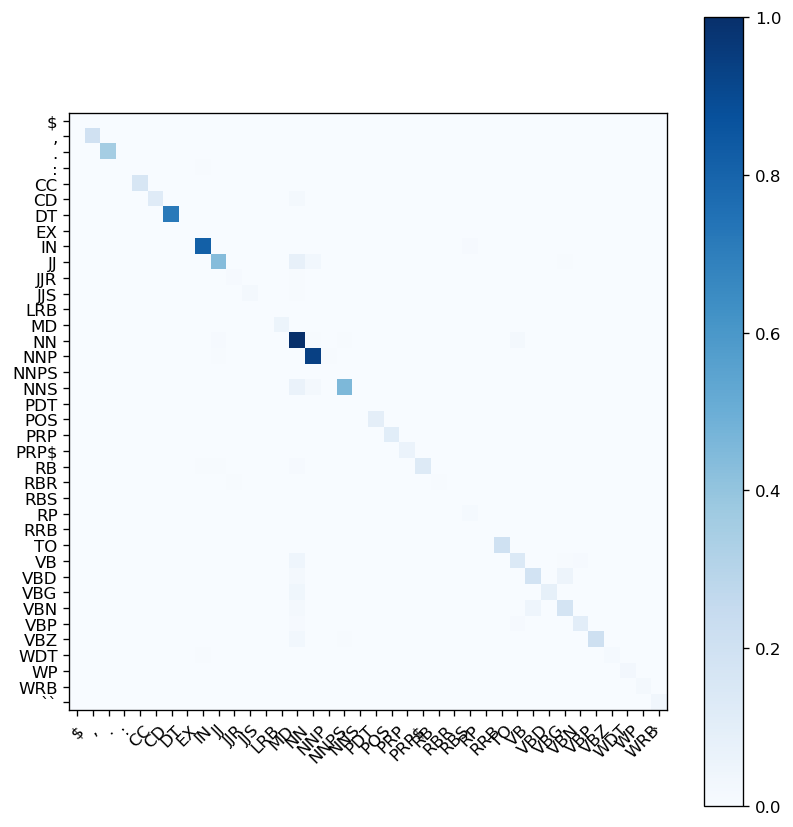

In [38]:
seq.plot_confusion_matrix(dev, local_2.predict(dev), normalise=True)

In [39]:
util.Carousel(local_2.errors(dev,
                             filter_gold=lambda y: y=='NN',
                             filter_guess=lambda y: y=='NNP'))

### Problem 2: ambiguity

*Polysemous* words or *homonyms* have multiple senses. For example, *back*:

Noun:

| | | | | | |
|-|-|-|-|-|-|
| He | is | treated | for | **back** | injury |
| PRP | VBP | VBN | IN | **NN** | NN |

Adverb:

| | | | | | |
|-|-|-|-|-|-|
| He | is | sent | **back** | to | prison |
| PRP | VBP | VBN | **RB** | TO | NN |

Verb:

| | | | | |
|-|-|-|-|-|
| I | can | **back** | this | up |
| PRP | MD | **VB** | DT | RP |

### What other features would you try for English POS tagging?

<center><img src="../../../../../img/quiz_time.png"></center>

# [tinyurl.com/diku-nlp-pos](https://tinyurl.com/diku-nlp-pos)

([Responses](https://docs.google.com/forms/d/1K8l0D6sTWmC4KmKJwr61zEN0eNjgUOpaDj3WSGxTuIM/edit#responses))

## Task: Named entity recognition (NER)


| |
|-|
| \[Barack Obama\]<sub>per</sub> was born in \[Hawaii\]<sub>gpe</sub> |


    per = Person
    gpe = Geopolitical Entity

... but this is not sequence labeling, is it?

## IOB encoding

Label tokens as beginning (B), inside (I), or outside (O) a **named entity:**

| | | | | | |
|-|-|-|-|-|-|
| Barack | Obama | was |  born | in | Hawaii |
| B-per | I-per | O |  O | O | B-gpe |


+ Many tasks can be framed as sequence labelling using this idea!

### Named entity types in GMB dataset

    geo = Geographical Entity
    org = Organization
    per = Person
    gpe = Geopolitical Entity
    tim = Time indicator
    art = Artifact
    eve = Event
    nat = Natural Phenomenon

Example sentence from GMB:

In [40]:
pd.DataFrame([tokens[12][:11], pos[12][:11], ents[12][:11]])

,0,1,2,3,4,5,6,7,8,9,10
0,Iran,'s,new,President,Mahmoud,Ahmadinejad,said,Tuesday,that,European,incentives
1,NNP,POS,JJ,NNP,NNP,NNP,VBD,NNP,IN,JJ,NNS
2,B-gpe,O,O,B-per,I-per,I-per,O,B-tim,O,B-gpe,O


In [41]:
examples = {}
counts_ent = Counter(tag[2:] for sent in ents for tag in sent if tag.startswith("B-"))
in_entity = False
for x_s, y_s in zip(tokens, ents):
    for i, (x, y) in enumerate(zip(x_s, y_s)):
        if y == "O":
            in_entity = False
            continue
        y_ent = y[2:]
        if y[0] == "B":
            if y_ent not in examples or random() > 0.6:
                examples[y_ent] = [x]
                in_entity = True
            else:
                in_entity = False
        if y[0] == "I" and in_entity:
            examples[y_ent].append(x)

sorted_ents = sorted(counts_ent.items(),key=lambda x:-x[1])
sorted_ents_with_examples = [(t,c," ".join(examples[t])) for t,c in sorted_ents]

sorted_ents_table = pd.DataFrame(sorted_ents_with_examples, columns=['Entity Type','Count','Example'])

In [42]:
sorted_ents_table

,Entity Type,Count,Example
0,geo,2070,Dujail
1,org,1237,Ethiopia and Eritrea
2,gpe,1230,Iraqi
3,tim,1160,1982
4,per,1107,Saddam Hussein
5,art,53,USA Today
6,eve,45,Summer Olympics
7,nat,20,H5N1


Can we run our simple **local model** on this?

In [48]:
train_ner = list(zip(tokens[:-200], ents[:-200]))
dev_ner = list(zip(tokens[-200:], ents[-200:]))

def feat_2(x,i):
    return {
        'bias': 1.0,
        'word:' + x[i].lower(): 1.0,
        'first_upper:' + str(x[i][0].isupper()): 1.0,
    }
local_2 = seq.LocalSequenceLabeler(feat_2, train_ner)
local_2_pred_dev = local_2.predict(dev_ner)
seq.accuracy(dev_ner, local_2_pred_dev)

0.9348182883939039

This seems great, but tag distribution is also **highly skewed**:

<BarContainer object of 13 artists>

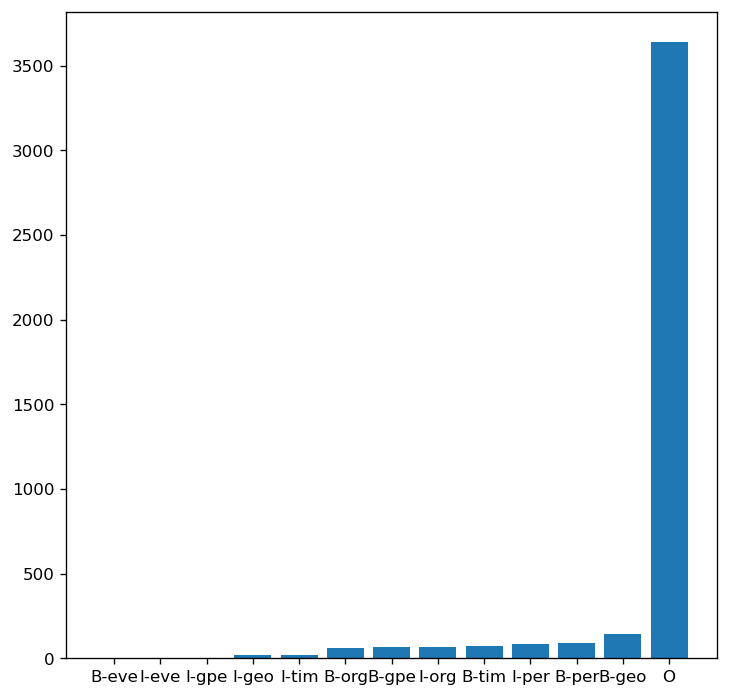

In [49]:
hist = Counter(tag for _, tags in dev_ner for tag in tags)
plt.bar(sorted(hist.keys(), key=hist.get), sorted(hist.values()))

A baseline that always predicts `O` is already pretty good:

In [50]:
only_o = [tuple(['O'] * len(tags)) for _, tags in dev_ner]
seq.accuracy(dev_ner, only_o)

0.8527549824150059

In [51]:
def get_spans(labels):
    spans = []
    current = [None, None, None]
    for i, label in enumerate(labels):
        if label.startswith("I-") and label[2:] == current[0]:
            # continued span
            continue
        # push span, if there is any
        if current[0] is not None:
            current[2] = i
            spans.append(current)
            current = [None, None, None]
        if label.startswith("B-"):
            current[0] = label[2:]
            current[1] = i
    if current[0] is not None:
        current[2] = len(labels)
        spans.append(current)
    return spans

def _calculate_prf(preds, golds):
    total_pred, total_gold, match = 0, 0, 0
    for pred, gold in zip(preds, golds):
        pred_s = get_spans(pred)
        gold_s = get_spans(gold)
        total_pred += len(pred_s)
        total_gold += len(gold_s)
        match += sum(s in pred_s for s in gold_s)
    # precision: % of entities found by the system that are correct
    p = match / total_pred if total_pred else 0.0
    # recall: % of entities in dataset found by the system
    r = match / total_gold if total_gold else 0.0
    # f-score: harmonic mean of precision and recall
    f = 2 * (p * r) / (p + r) if p + r else 0.0

    return p, r, f

def print_prf(goldset, preds):
    p, r, f = _calculate_prf(preds, [s[1] for s in goldset])
    print(f"precision: {p:.2f}\nrecall: {r:.2f}\nf-score: {f:.2f}")

Tasks like NER are more commonly evaluated with...

### Precision, recall, and F-score

\begin{align}
\text{precision} & = \frac{|\text{predicted}\cap\text{annotated}|}{|\text{predicted}|} \\[.5em]
\text{recall} & = \frac{|\text{predicted}\cap\text{annotated}|}{|\text{annotated}|} \\[.5em]
F & = 2 \cdot \frac{\text{precision}\cdot\text{recall}}{\text{precision}+\text{recall}} \\
\end{align}


Example:

In [52]:
pd.DataFrame([dev_ner[18][0], dev_ner[18][1], local_2_pred_dev[18]])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,The,newspaper,says,the,tape,was,shot,in,2004,in,southern,Iraq,.
1,O,O,O,O,O,O,O,O,B-tim,O,B-geo,I-geo,O
2,O,O,O,O,O,O,O,O,B-tim,O,O,B-geo,O


predicted = {2004, Iraq}

annotated = {2004, southern Iraq}

In [53]:
print_prf([dev_ner[18]], [local_2_pred_dev[18]])

precision: 0.50
recall: 0.50
f-score: 0.50


back to the full dev set...

In [54]:
local_2_pred_dev = local_2.predict(dev_ner)
print_prf(dev_ner, local_2_pred_dev)

precision: 0.73
recall: 0.59
f-score: 0.65


In [55]:
print_prf(dev_ner, only_o)

precision: 0.00
recall: 0.00
f-score: 0.00


## Sequence labelling with neural networks

We can use BiLSTMs for that!

<center>
  <img style="width:30%;" src='../../../../../img/genthial_bilstm.png'/>
</center>

<span class="font-size:small;">Source: https://guillaumegenthial.github.io/sequence-tagging-with-tensorflow.html</span>

### Reminder
A recurrent neural network (plain RNN, LSTM, GRU, ...) computes its output based on a hidden, internal state:

$$
 {\mathbf{y}}_{t} = \text{RNN}(\x_t, {\mathbf{h}}_{t})
$$



A **bi-directional** RNN is just two uni-directional RNNs combined:

\begin{align}
 \overrightarrow{\mathbf{y}_{t}} & = \overrightarrow{\text{RNN}}(\x_t, \overrightarrow{\mathbf{h}_{t}})\\
 \overleftarrow{\mathbf{y}_{t}} & = \overleftarrow{\text{RNN}}(\x_t, \overleftarrow{\mathbf{h}_{t}})
 \\
 {\mathbf{y}}_{t} & = \overrightarrow{\mathbf{y}_{t}} \oplus \overleftarrow{\mathbf{y}_{t}} \\
\end{align}


To predict label probabilities, we use the **softmax function**:


$$
\begin{aligned}
 {\mathbf{y}}_{t} & = \overrightarrow{\mathbf{y}_{t}} \oplus \overleftarrow{\mathbf{y}_{t}} \\
 \hat{\mathbf{y}}_{t} & = \text{softmax}(\mathbf{W}^o \mathbf{y}_{t}) \in \mathbb{R}^{|V|} \\
\end{aligned}
$$


We can also use transformers such as BERT
![bert_ner](../../../../../img/bert_ner.png)

### Note on tokenisation

Parts of speech are defined for *words*.

Tagger must output one tag per word even if using other tokenisation internally.

### Tokenisation
Combining word representations with character representations improves POS tagging:

<center>
  <img src='../../../../../img/bplank_bilstm.png'/>
</center>

([Plank et al., 2016](https://aclanthology.org/P16-2067/))

### An important technical detail

The linear transformation $\mathbf{W}^o \mathbf{y}_{t}$ is usually not modelled as part of the RNN itself in most deep learning frameworks.

Instead, look for one of

+ **feed-forward layer**
+ **dense layer** (*e.g. in Keras*)
+ **linear layer** (*e.g. in PyTorch*)

with a softmax activation

### Is it all the same?

Remember the log-linear classifier:

$$
  p_\params(y\bar\x,i) = \frac{1}{Z_\x} \exp \langle \repr(\x,i),\params_y \rangle
$$

A neural sequence model with a softmax layer on top is also modelling $p_\params(y\bar\x,i)$

So if you take $\params$ to be the set of parameters of the neural network, then:

\begin{align}
 \hat{\mathbf{y}}_{t} & = \text{softmax}(\hat{\mathbf{h}}_{t}) \\
  &= \frac{1}{Z_\x} \exp \langle \hat{\mathbf{h}}_{t},\params_y \rangle \\
\end{align}

### What is the difference?

<center><img src="../../../../../img/quiz_time.png"></center>

# [tinyurl.com/diku-nlp-seq](https://tinyurl.com/diku-nlp-seq)

([Responses](https://docs.google.com/forms/d/1X6LKsQ3a9_XcsZm5gpa8p-q9brXosjlbTubp2nqR1pk/edit#responses))

### Solution

* Incorrect: That neural sequence models can use context: log-linear models can too
* Correct: That neural sequence models have more parameters (generally)
* Incorrect: That neural sequence models are global (not local) models (both can be either local or global)
* Correct: That neural sequence models learn features on their own
* Correct: That log-linear models can only combine features linearly
* Incorrect: That log-linear models perform greedy inference
* Incorrect: That log-linear models can only use the left context (preceding tokens)

What haven't we modelled yet?

## There are *dependencies* between consecutive labels!

Can you think about fitting words for this POS tag sequence?

| | | |
|-|-|-|
| DT | JJ | NN |
| *determiner* | *adjective* | *noun (singular or mass)* |

What about this one?

| | |
|-|-|
| DT | VB |
| *determiner* | *verb (base form)* |

+ After determiners (`DT`), adjectives and nouns are much more likely than verbs
+ *Local* models cannot *directly* capture this

In [56]:
util.Carousel(local_2.errors(dev_ner,
                             filter_guess=lambda y: y.startswith("I-"),
                             filter_gold=lambda y: y.startswith("B-")))

In the IOB tagging scheme:

+ `I-[label]` can logically **only** appear after `B-[label]`!

The following can **never** be valid tag sequences:

* `O  I-per`

* `B-per  I-geo`


Remember that

$$
p_\params(\y|\x) = \prod_{i=1}^n p_\params(y_i|\x,i,y_{1,\ldots,i-1})
$$

What if we went from this...

$$
\approx \prod_{i=1}^n p_\params(y_i|\x,i)
$$

...to this?

$$
\approx \prod_{i=1}^n p_\params(y_i|\x,\color{red}{y_{i-1}},i)
$$


Does this remind you of anything you've seen in previous lectures?

### First-order Markov assumption

* Probability of a label depends only on (the input and) the previous label


### Example

$$
\prob_\params(\text{"O I-per I-per"} \bar \text{"president Bill Clinton"}) = \\
\prob_\params(\text{"O"}\bar \text{"president Bill Clinton"},\text{"<PAD>"},1) ~ \cdot \\
\prob_\params(\text{"I-per"} \bar \text{"president Bill Clinton"},\text{"O"},2) ~ \cdot \\
\prob_\params(\text{"I-per"} \bar \text{"president Bill Clinton"},\text{"I-per"},3) \\
$$

## Maximum Entropy Markov Models (MEMM)

Log-linear version with access to previous label:

$$
  p_\params(y_i|\x,y_{i-1},i) = \frac{1}{Z_{\x,y_{i-1},i}} \exp \langle \repr(\x,y_{i-1},i),\params_{y_i} \rangle
$$

where
$$Z_{\x,y_{i-1},i}=\sum_y \exp \langle \repr(\x,y_{i-1},i),\params_{y_i} \rangle$$
is a *local* per-token normalisation factor.

### Graphical Representation

- Reminder: models can be represented as factor graphs
- Each variable of the model (our per-token tag labels and the input sequence $\x$) is drawn using a circle
- As before, *observed* variables are shaded
- Each factor in the model (terms in the product) is drawn as a box that connects the variables that appear in the corresponding term

### Training MEMMs
Optimising the conditional log-likelihood

$$
\sum_{(\x,\y) \in \train} \log \prob_\params(\y|\x)
$$

Decomposes nicely:
$$
\sum_{(\x,\y) \in \train} \sum_{i=1}^{|\x|} \log \prob_\params(y_i|\x,y_{i-1},i)
$$

Easy to train
* Equivalent to a **logistic regression objective** for a classifier that assigns labels based on previous gold labels

However...

### Local normalisation introduces *label bias*

+ Tag probabilities always sum to 1 at each position
+ Can lead to MEMMs effectively "ignoring" the inputs

## Conditional Random Fields (CRF)

Replace *local* with *global* normalisation.

Instead of normalising across all possible next states $y_{i+1}$ given a current state $y_i$ and observation $\x$,

the CRF normalises across all possible *sequences* $\y$ given observation $\x$.

Formally:

$$
  p_\params(y_i|\x,y_{i-1},i) = \frac{1}{Z_{\x}} \exp \langle \repr(\x,y_{i-1},i),\params_{y_i} \rangle
$$

where
$$Z_{\x}=\sum_\y   \prod_i^{|\x|} \exp \langle \repr(\x,y_{i-1},i), \params_{y_i} \rangle$$
is a *global* normalisation constant depending on $\x$.

Notably, each term $\exp  \langle \repr(\x,y_{i-1},i), \params_{y_i} \rangle$ in the product can now take on values in $[0,\infty)$ as opposed to the MEMM terms in $[0,1]$.  

***

+ More precisely, this is a **linear-chain CRF**.

  (CRFs can be applied to any graph structure, but we are only considering sequences.)


## Pros and cons of CRFs


### &#128077;

+ Finds globally optimal label sequence
+ Eliminates label bias

### &#128078;

+ More difficult to train (—cannot break down into local terms anymore!)

The best of both worlds?

## Neural CRF

+ We can **combine** our neural sequence models with a CRF!


$$
  p_\params(y_i|\x,y_{i-1},i) = \frac{1}{Z_{\x}} \exp \langle \hat{\mathbf{h}}_{t},\params_{y_i} \rangle
$$


![](https://www.gabormelli.com/RKB/images/thumb/1/1e/N16-1030_fig1.png/400px-N16-1030_fig1.png)

(from [Lample et al., 2016](https://www.aclweb.org/anthology/N16-1030))

## Prediction in MEMMs, CRFs, neural CRFs, ...

To predict the best label sequence, find a $\y^*$ with maximal conditional probability

$$
\y^* =\argmax_\y \prob_\params(\y|\x).
$$

## Greedy Prediction

Simplest option:
* Choose highest scoring label for token 1
* Choose highest scoring label for token 2, conditioned on best label from 1
* etc.

But...

+ May lead to **search errors** when returned $\y^*$ is not highest scoring **global** solution

### Problem

We cannot simply choose each label in isolation because **decisions depend on each other.**

## Beam Search

Keep a "beam" of the best $\beta$ previous solutions

1. Choose $\beta$ highest scoring labels for token 1
2. 1. For each of the previous $\beta$ labels: predict probabilities for next label, conditioned on the previous label(s)
   2. **Sum** the log-likelihoods for previous states and next label
   3. **Prune** the beam by only keeping the top $\beta$ paths
3. Repeat until end of sequence

## Summary


- Many problems can be cast as sequence labelling
    - POS tagging
    - Named entity recognition (with IOB encoding)
    
- Models are similar to sequence **classifiers** but are sequential
    - Log-linear models rely on good feature engineering
    - Neural sequence labelers rely on substantial amounts of training data but generally perform better


## Background Material 

- Longer introduction to sequence labelling with linear chain models: [notes](chapters/sequence_labeling.ipynb)
- Longer introduction to sequence labelling with CRFs: [slides](chapters/sequence_labeling_crf_slides.ipynb)

- Jurafsky & Martin, Speech and Language Processing, [Chapter 17](https://web.stanford.edu/~jurafsky/slp3/17.pdf)
- Tutorial on CRFs: Sutton & McCallum, [An Introduction to Conditional Random Fields for Relational Learning](https://people.cs.umass.edu/~mccallum/papers/crf-tutorial.pdf)
- LSTM-CRF architecture: [Huang et al., Bidirectional LSTM-CRF for Sequence Tagging](https://arxiv.org/pdf/1508.01991v1.pdf)
- Globally Normalized Transition-Based Neural Networks: [Andor et al., 2016](https://arxiv.org/abs/1603.06042)